# Platform for testing wide-area monitoring methods in electric power systems

In real-time operation, electric power systems are constantly evolving with scheduled and unscheduled events disturbing their operation. A cascade of hierarchical monitoring and control methods (automatic and manual) are put in place to constantly survey the system status and react accordingly. The most promissing, but at the same time most demanding in terms of infrastructure, methods are based on wide-area monitoring and control (WAMC). 

WAMC methods require a sensors and communication network to enable single or bi-directional flow of data from the control center to the distributed devices. These methods provide a more global view of the system (i.e., better observability) and can coordinate various resources to better address the problems that arise (i.e., better controlability). There are many such methods proposed in literature, either for monitoring and stability/security detection or for coordinating recourses to tackle system-wide problems. Some methods consider fast or slow monitoring systems, the existence or not of communication delays, fast or slow dynamics, etc.

A big problem for researchers is the lack of realistic platforms to test these methods. Historical data from real systems are hard to acquire and are usually biased towards normal operation (due to the high reliability of power systems). Moreover, it is impossible to implement remedial actions using historical data. For this reason, dynamic simulation models are used to emulate the underlying system and provide real-time "measurements" to be used in the wide-area method. Such systems are hard to set up, especially for people not familiar with dynamic simulations.

In this post, I will show an example of testing a wide-area monitoring (WAM) algorithm using the dynamic simulation software [pyramses](https://pyramses.paristidou.info) and the well-known [Nordic test](https://resourcecenter.ieee-pes.org/technical-publications/technical-reports/PESTR19.html) (shown in the figure below). The monitoring algorithm uses PMU data to detect voltage instability problems and is detailed in [\[1\]](#bib).

If you want to execute this Jupyter Notebook, you would need to install [pyramses](https://pyramses.paristidou.info) and get the rest of the data from [here](https://www.dropbox.com/sh/bfma45h6d1i3pb9/AAARm1sCyJGAL9XmyNeFbFmIa?dl=1).

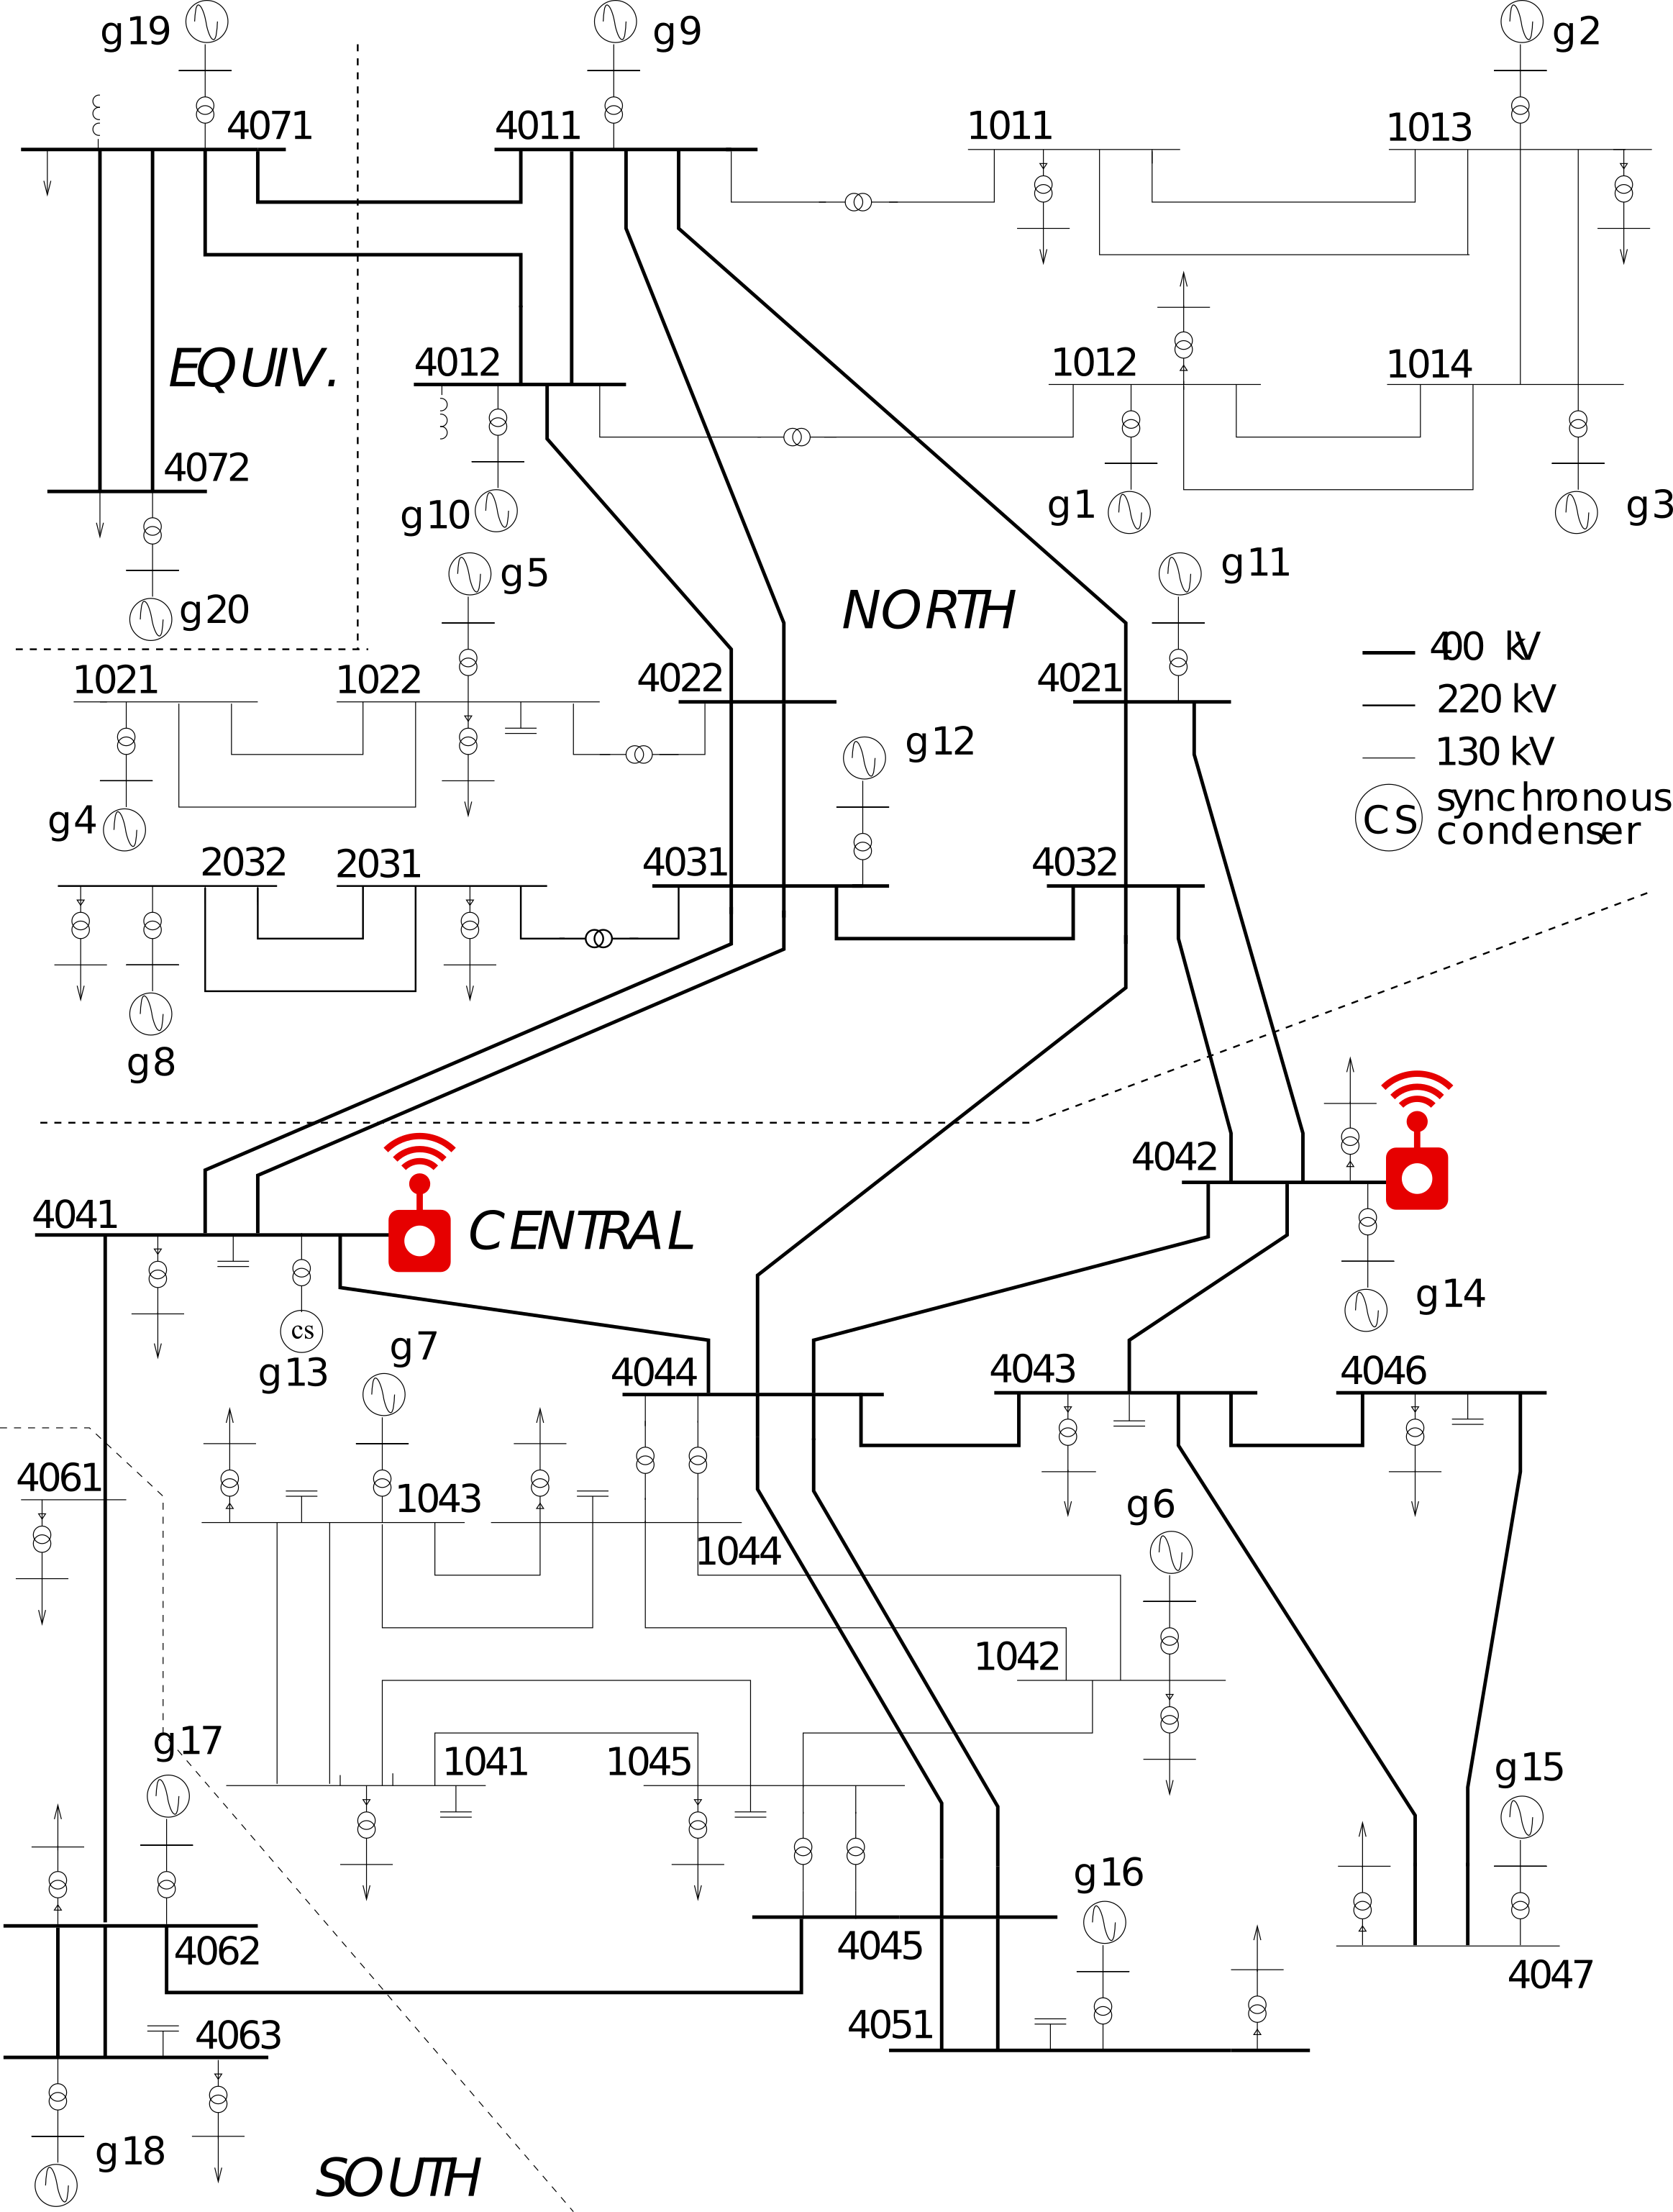

In [1]:
from IPython.display import Image
Image(filename='Nordic32.png')

# Scenario setup

In this section, we set up the scenario to be analysed and monitored. First, we load the required modules: 

In [2]:
import pyramses
import cmath
import numpy as np
import matplotlib.pyplot as plt

where:

- [pyramses](https://pyramses.paristidou.info): This is the dynamic simulator used to emulate the underlying dynamic system
- cmath and numpy: These are standard Python libraries for mathematical computations
- matplotlib: This is used to plot the results

The next step is to load the data that describe the underlying dynamic test system. In this case, we are analysing operating point A of the Nordic system as described in [\[2\]](#bib). All the files are simple text files and their structure is detailed in the website of [pyramses](https://pyramses.paristidou.info).

In [3]:
case = pyramses.cfg() # Create a new scenario
case.addData('dyn_A.dat') # Dynamic data file
case.addData('volt_rat_A.dat') # Power-flow (static) data
case.addData('settings1.dat') # Solver settings
case.addObs("obs.dat") # File with the variables to be saved for offline analysis
case.addTrj("out.trj") # File for saving the variables for offline analysis

Then, the file describing the disturbance to be analysed should be loaded. The event considered is the same as in the paper: A 5-cycle short circuit on bus 4032 at $t=1s$, followed by the tripping of line 4032–4044.

In [4]:
case.addDst('short_trip_branch.dst') # Description of disturbance

## Define the boundary buses to monitor

An important part of the monitoring method is to define the buses and lines to be monitored by the PMUs. These are selected to be the same as in [\[1\]](#bib).

In [5]:
branchName = ['4031-4041','4031-4041-2','4021-4042','4032-4042'] # Lines to be monitored
busName = ['4041','4042'] # Buses to be monitored

## Define empty lists to save running values

The algorithm relies heavily on multiple moving averages over a time window. So, we need to define the lists to keep the values historically:

In [6]:
lP4041 = [] ; lP4042 = [] ; lG4041 = [] ; lG4042 = []
lDeltaG4041 = [] ; lDeltaG4042 = [] ; lDeltaP4041 = [] ; lDeltaP4042 = []
NLI4041 = [] ; NLI4042 = []
avNLI4041 = [] ; avNLI4042 = []
time4041 = [] ; time4042 = [] ; rawtime = []

## Define monitoring parameters

The monitoring parameters required by the algorithm are defined as:

In [7]:
epsilon = 0.001
N = 10  # samples
thorizon = 200.0 # seconds
Tsample = 0.5 # seconds

where $\epsilon$ is the threshold used to filter out measurements as discussed in Eq. 15 of [\[1\]](#bib), $N$ defines the number of samples averaged for all averaging functions, $T_{sample}$ is the sampling time for getting the measurements, and $thorizon$ is the simulation time if a fault is not found first.

## Define support functions

There are two support functions implemented here to get the measurements and compute the NLI indices. If you are not familiar with the methodology, you can skip reading them. 

The function *get_measurements* gets a measurements of the active powers and currents on the boundary buses. Unlike the paper, we do not add any measurement noise.

In [8]:
def get_measurements(ram, busName, branchName):

    # Returns a list where each element has the from/to active/reactive powers of a branch. All values are in per-unit.
    # Powers list contains the following:
    # [[4031-4041-Porig, 4031-4041-Qorig, 4031-4041-Pextr, 4031-4041-Pextr]
    #  [4031-4041-2-Porig, 4031-4041-2-Qorig, 4031-4041-2-Pextr, 4031-4041-2-Pextr]
    #  [4021-4042-Porig, 4021-4042-Qorig, 4021-4042-Pextr, 4021-4042-Pextr]
    #  [4032-4042-Porig, 4032-4042-Qorig, 4032-4042-Pextr, 4032-4042-Pextr]]
    # All the powers are assumed towards the line. That is, the lines losses are Ploss = Porig+Pextr, Qloss = Qorig+Qextr
    # The minus sign below is used because we want the power going into the bus.
    powers = ram.getBranchPow(branchName) 
    P4041 = - (powers[0][2] + powers[1][2])
    P4042 = - (powers[2][2] + powers[3][2])
    
    # Returns a list where each element has the from/to x/y current component of a branch. All values are in per-unit.
    # The list below has the same structure as the one above
    currents = ram.getBranchCur(branchName) 
    Ix4041 = - (currents[0][2] + currents[1][2])
    Iy4041 = - (currents[0][3] + currents[1][3])
    Ix4042 = - (currents[2][2] + currents[3][2])
    Iy4042 = - (currents[2][3] + currents[3][3])
    
    I4041 = complex(Ix4041, Iy4041)
    I4042 = complex(Ix4042, Iy4042)
        
    # Return the bus voltage magnitude and phase
    voltageMag = ram.getBusVolt(busName)
    voltagePha = ram.getBusPha(busName)
    
    # Formulate complex voltages of the boundary bases
    voltage4041 = cmath.rect(voltageMag[0], voltagePha[0])
    voltage4042 = cmath.rect(voltageMag[1], voltagePha[1])
           
    #Compute the conductance
    G4041 = (I4041 / voltage4041).real
    G4042 = (I4042 / voltage4042).real
    
    return P4041, P4042, G4041, G4042

The function *update_NLI* updates the NLI index at time t for each of the boundary buses:

In [9]:
def update_NLI(t, lP, lG, N, epsilon, lDeltaG, lDeltaP, NLI, avNLI, time):
    if len(lP) > 2:
        # Compute eqs. 13-14 in [1]
        if len(lG) > N+1 :
            DeltaG = np.mean(lG[-N:-1]) - np.mean(lG[-N-1:-2])
            DeltaP = np.mean(lP[-N:-1]) - np.mean(lP[-N-1:-2])
        else:
            DeltaG = np.mean(lG[:-1]) - np.mean(lG[:-2])
            DeltaP = np.mean(lP[:-1]) - np.mean(lP[:-2])
        
        # Check eq 15 in [1] if the measurement is acceptable
        if (DeltaG / lG[-1]) > epsilon: 
            lDeltaG.append(DeltaG)
            lDeltaP.append(DeltaP)
            if len(lDeltaP) > N:
                # Compute eq. 17 in [1]
                NLIk = np.mean(lDeltaP[-N:-1]) / np.mean(lDeltaG[-N:-1])
                NLI.append(NLIk)
                if len(NLI) > N:
                    # Compute moving average of eq. 17 in [1]
                    avNLI.append(np.mean(NLI[-N:-1]))  
                    time.append(t)

# Execute simulation and monitoring

To emulate the underlying system, we run a dynamic simulation and _pause_ it every $Tsample$ to read the measurement variables. Then, we can run the detection algorithm before continuing to the next time step.

First, we start the simulation paused at $t=0~s$.

In [10]:
ram = pyramses.sim() # Create a new simulator instance
ret = ram.execSim(case, 0) # Start the simulation of the scenarion paused at t=0 seconds

Then, we run the remaining of the system analysis. The simulation-monitoring loop stops when we reach the time horizon or when we have a violation of voltage or machine speed constraints.

In [11]:
for t in np.arange(0.0,thorizon,Tsample):
    
    # Simulates until the next sampling point. If there is an error, then exit the loop printing the error.
    try:
        ram.contSim(t)
    except:
        print(ram.getLastErr())
        break
    
    # Get the recent measurements of Power (P) and Conductance (G)
    P4041, P4042, G4041, G4042 = get_measurements(ram, busName, branchName)
    
    # Update the values of NLI
    update_NLI(t, lP4041, lG4041, N, epsilon, lDeltaG4041, lDeltaP4041, NLI4041, avNLI4041, time4041)
    update_NLI(t, lP4042, lG4042, N, epsilon, lDeltaG4042, lDeltaP4042, NLI4042, avNLI4042, time4042)
    
    # Update the list of measurements
    lP4041.append(P4041)
    lP4042.append(P4042)
    lG4041.append(G4041)
    lG4042.append(G4042)
    rawtime.append(t)

ERROR CALL FROM DCTL sim_minmaxvolt MINMAXVOLT_Stopping t =  162.3600         Voltage out of bounds at bus g6 :  0.70


You can see after the cell execution above that the simulation stopped because we had a **Voltage out of bounds at bus g6**. We will see in the results that this is due to a long-term voltage instability event.

# Results

In this section, we show the results of the WAM algorithm, trying to replicate some of the figures in [\[1\]](#bib). The first figure below replicates Fig. 9 of [\[1\]](#bib). We can see the long-term voltage evolution leading to a voltage collapse around $t=160~s$. The mechanisms driving the instability are analysed and discussed in [\[1-2\]](#bib).

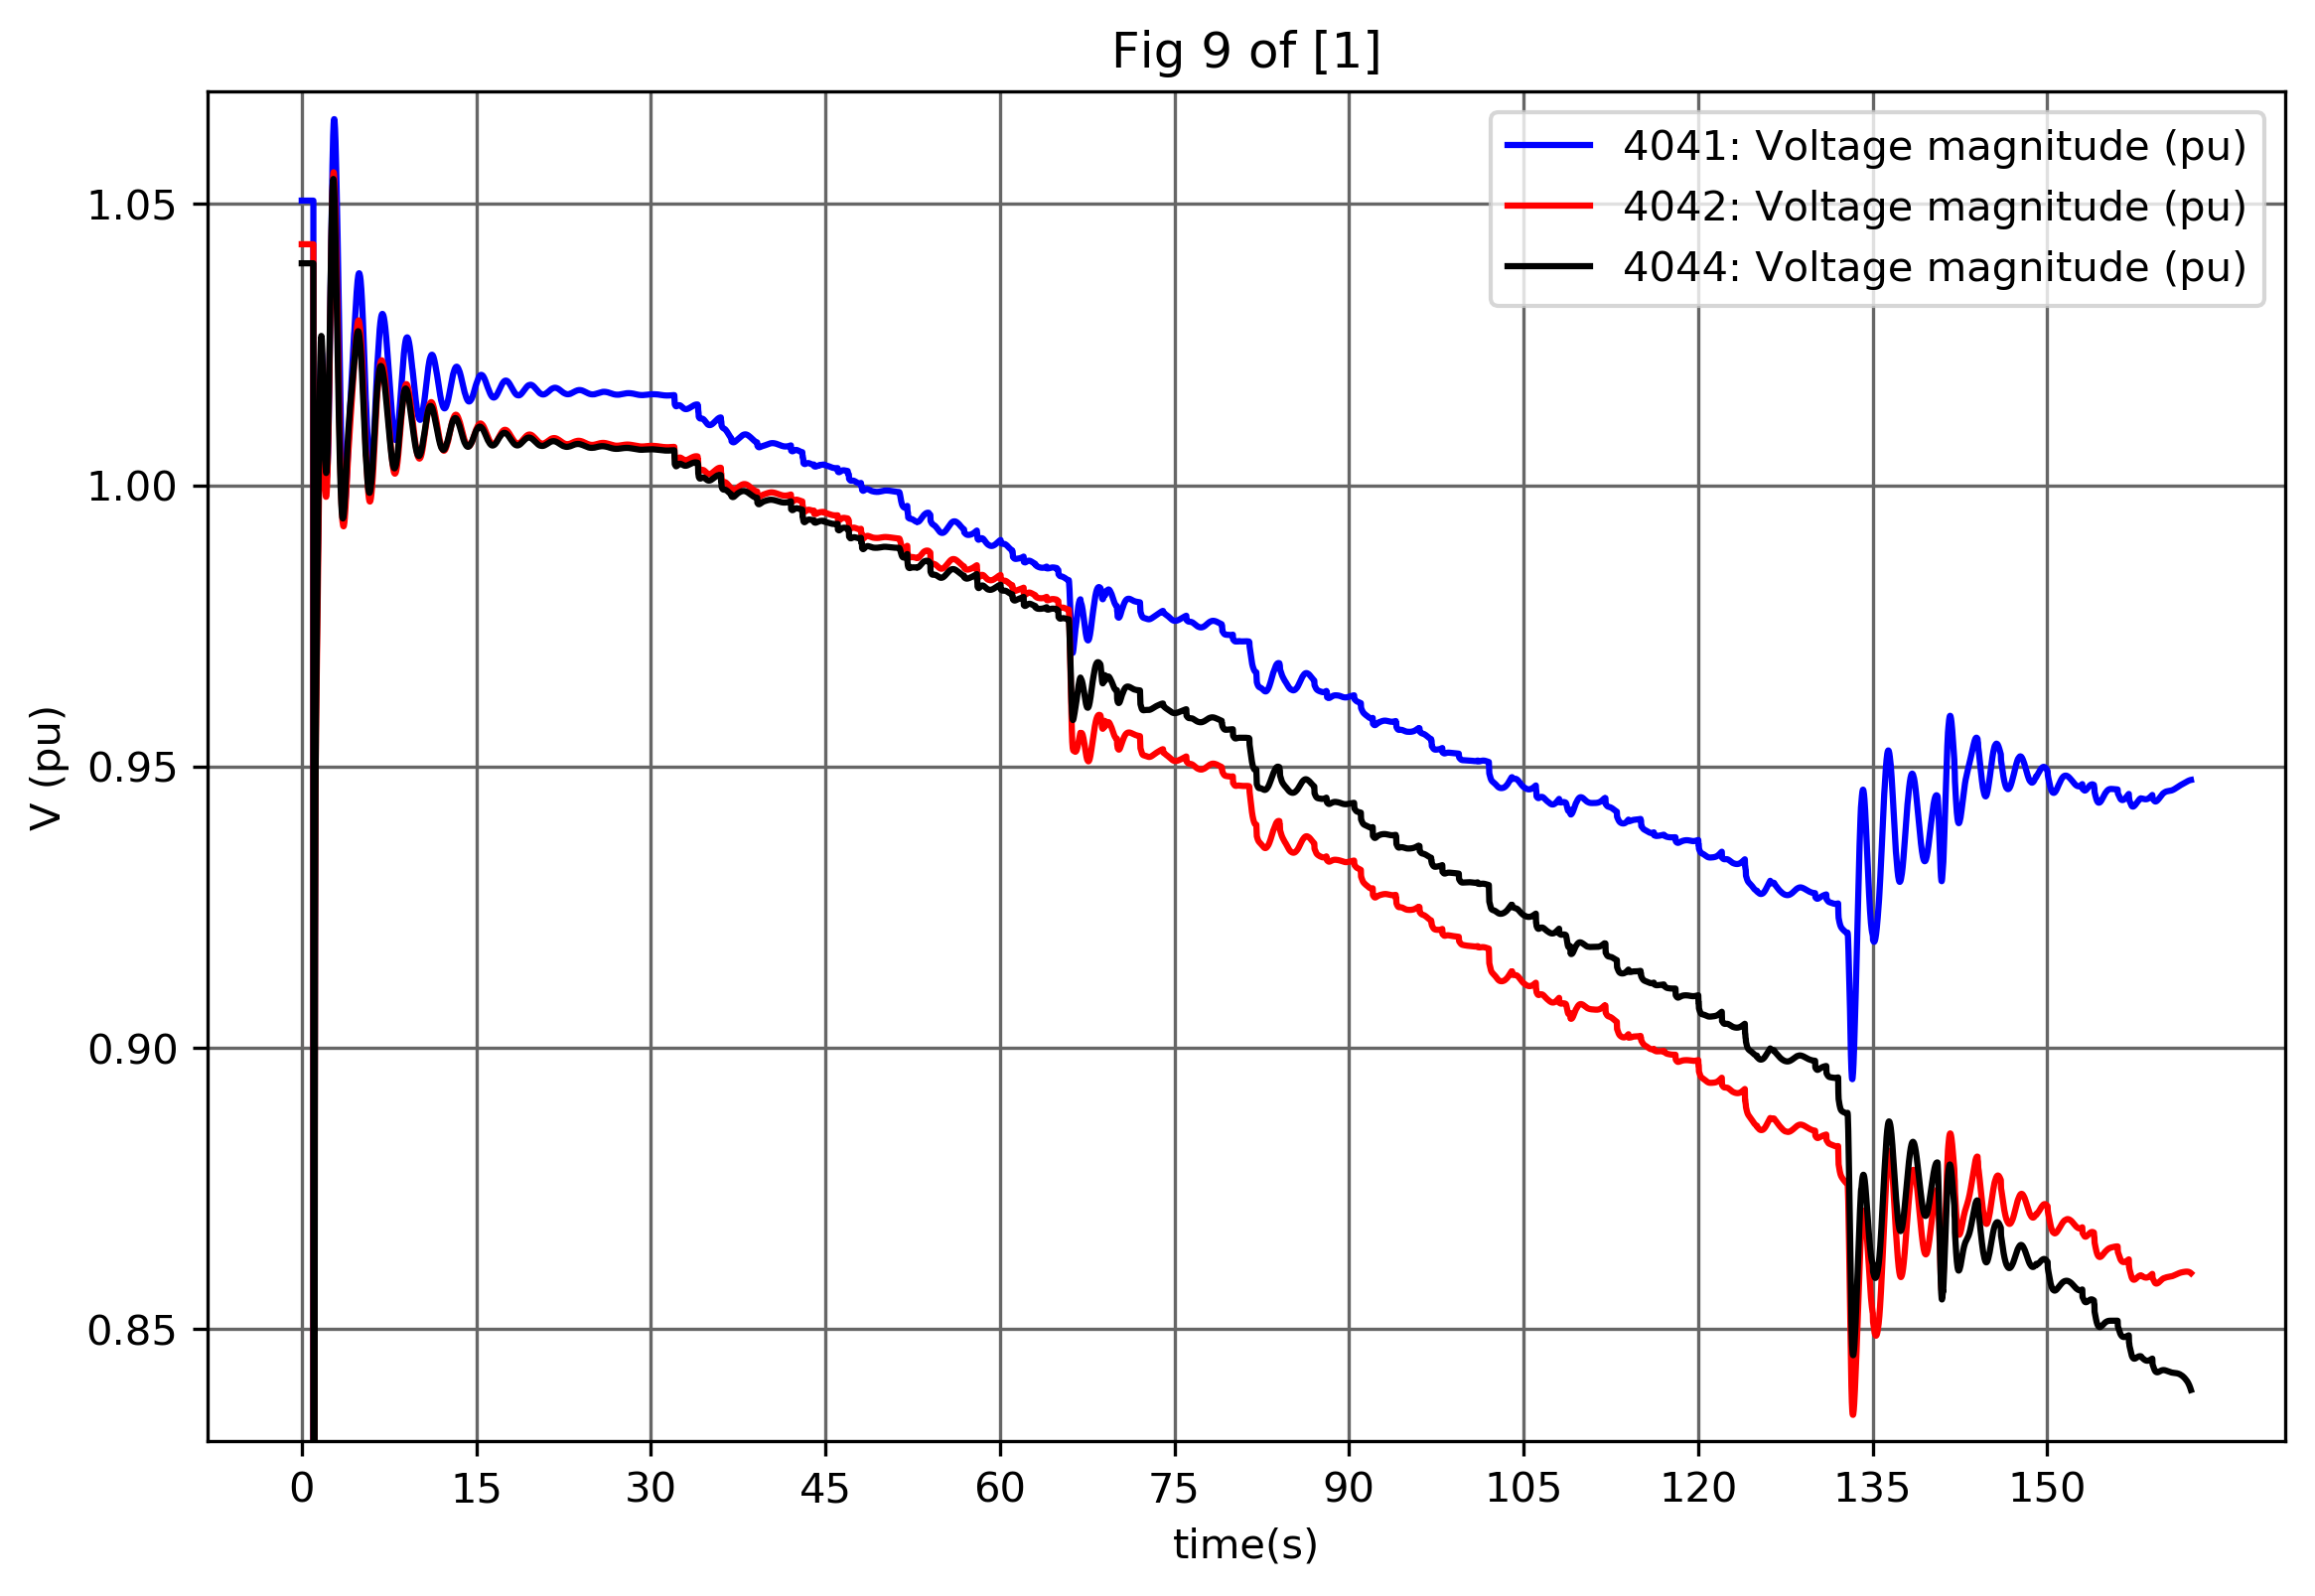

In [12]:
ext = pyramses.extractor(case.getTrj())
v4041 = ext.getBus('4041').mag
v4042 = ext.getBus('4042').mag
v4044 = ext.getBus('4044').mag
fig=plt.figure(figsize=(9,6), dpi= 300, facecolor='w', edgecolor='k')
plt.plot(v4041.time, v4041.value, 'b', label=v4041.msg)
plt.plot(v4042.time, v4042.value, 'r', label=v4042.msg)
plt.plot(v4044.time, v4044.value, 'k', label=v4044.msg)
plt.ylabel('V (pu)')
plt.xlabel('time(s)')
plt.legend(loc='upper right')
plt.xticks(np.arange(0, 160, 15))
plt.yticks(np.arange(0.85, 1.05, 0.05))
plt.ylim(0.83, 1.07)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.title('Fig 9 of [1]')
plt.show()

The figure below replicates Fig. 15 of [\[1\]](#bib). It shows the evolution of the NLI on both buses and it can be seen that around $t=75~s$ NLI4042 crosses the zero line.

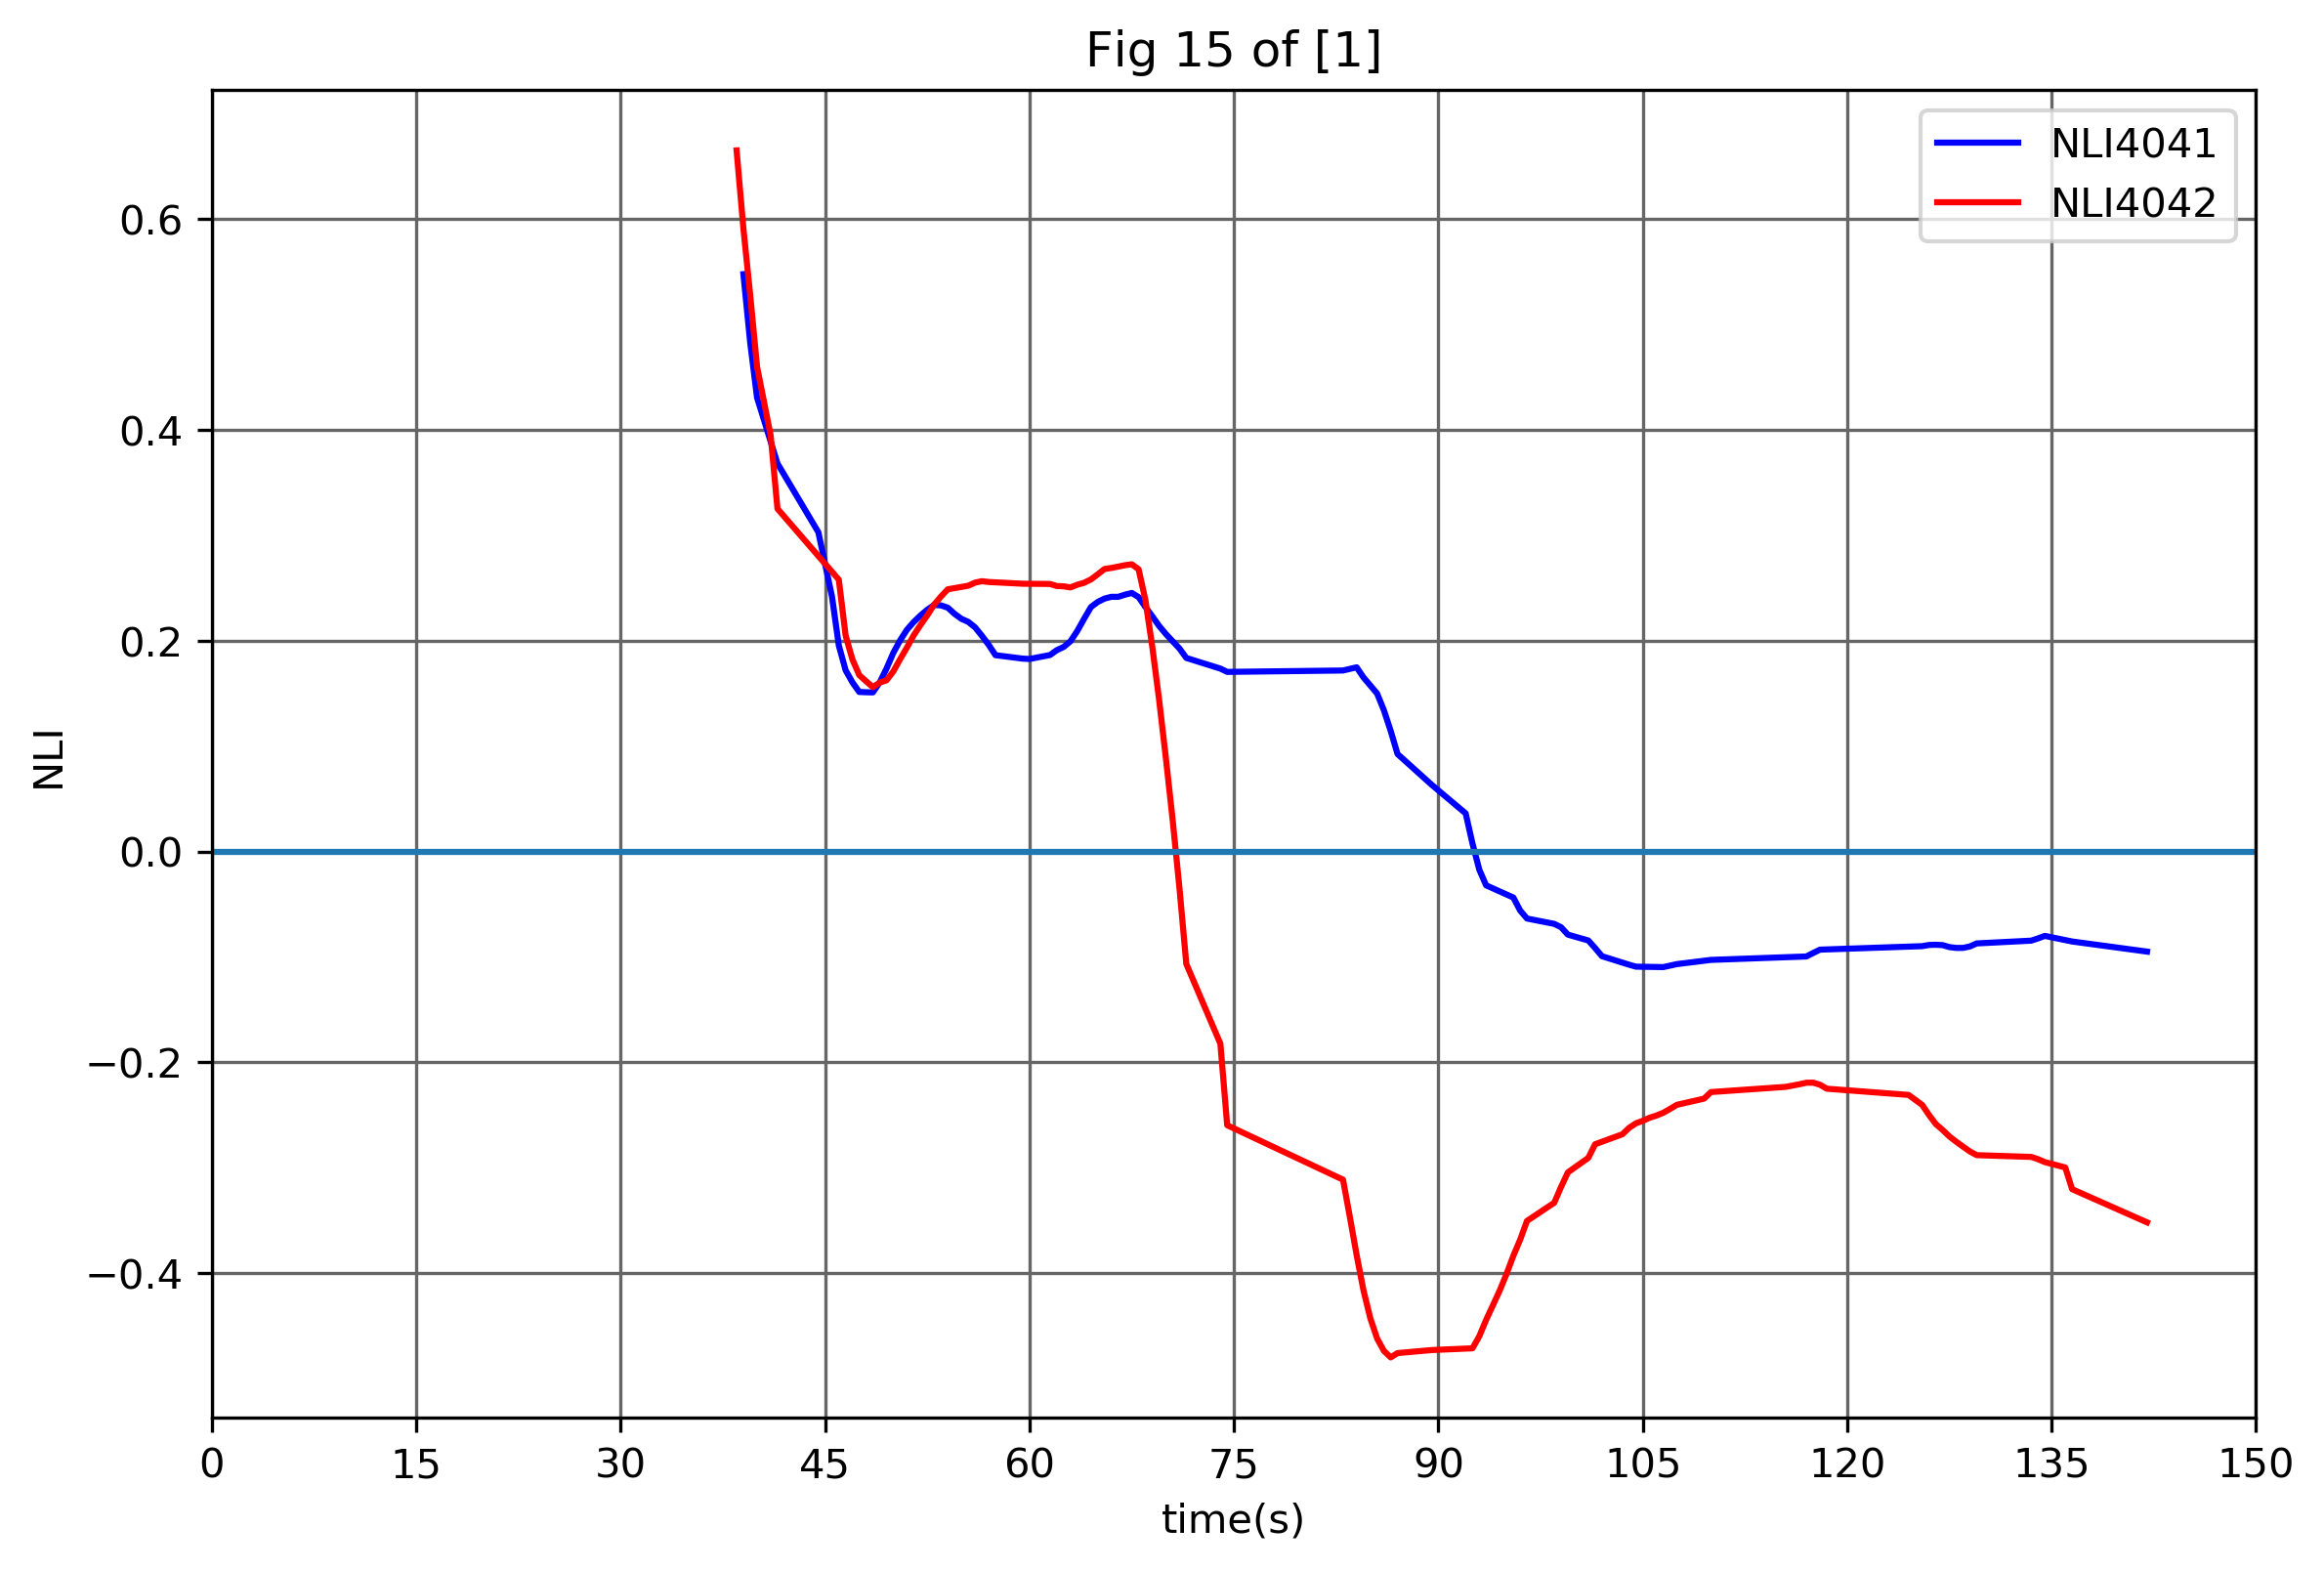

In [13]:
fig=plt.figure(figsize=(9,6), dpi= 300, facecolor='w', edgecolor='k')
plt.plot(time4041, avNLI4041, 'b', label="NLI4041")
plt.plot(time4042, avNLI4042, 'r', label="NLI4042")
plt.axhline(y=0.0)
plt.ylabel('NLI')
plt.xlabel('time(s)')
plt.legend(loc='upper right')
plt.xticks(np.arange(0, 160, 15))
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.title('Fig 15 of [1]')
plt.show()

The figure below replicates Fig. 13 of [\[1\]](#bib). We can see the evolution of the power and conductance.

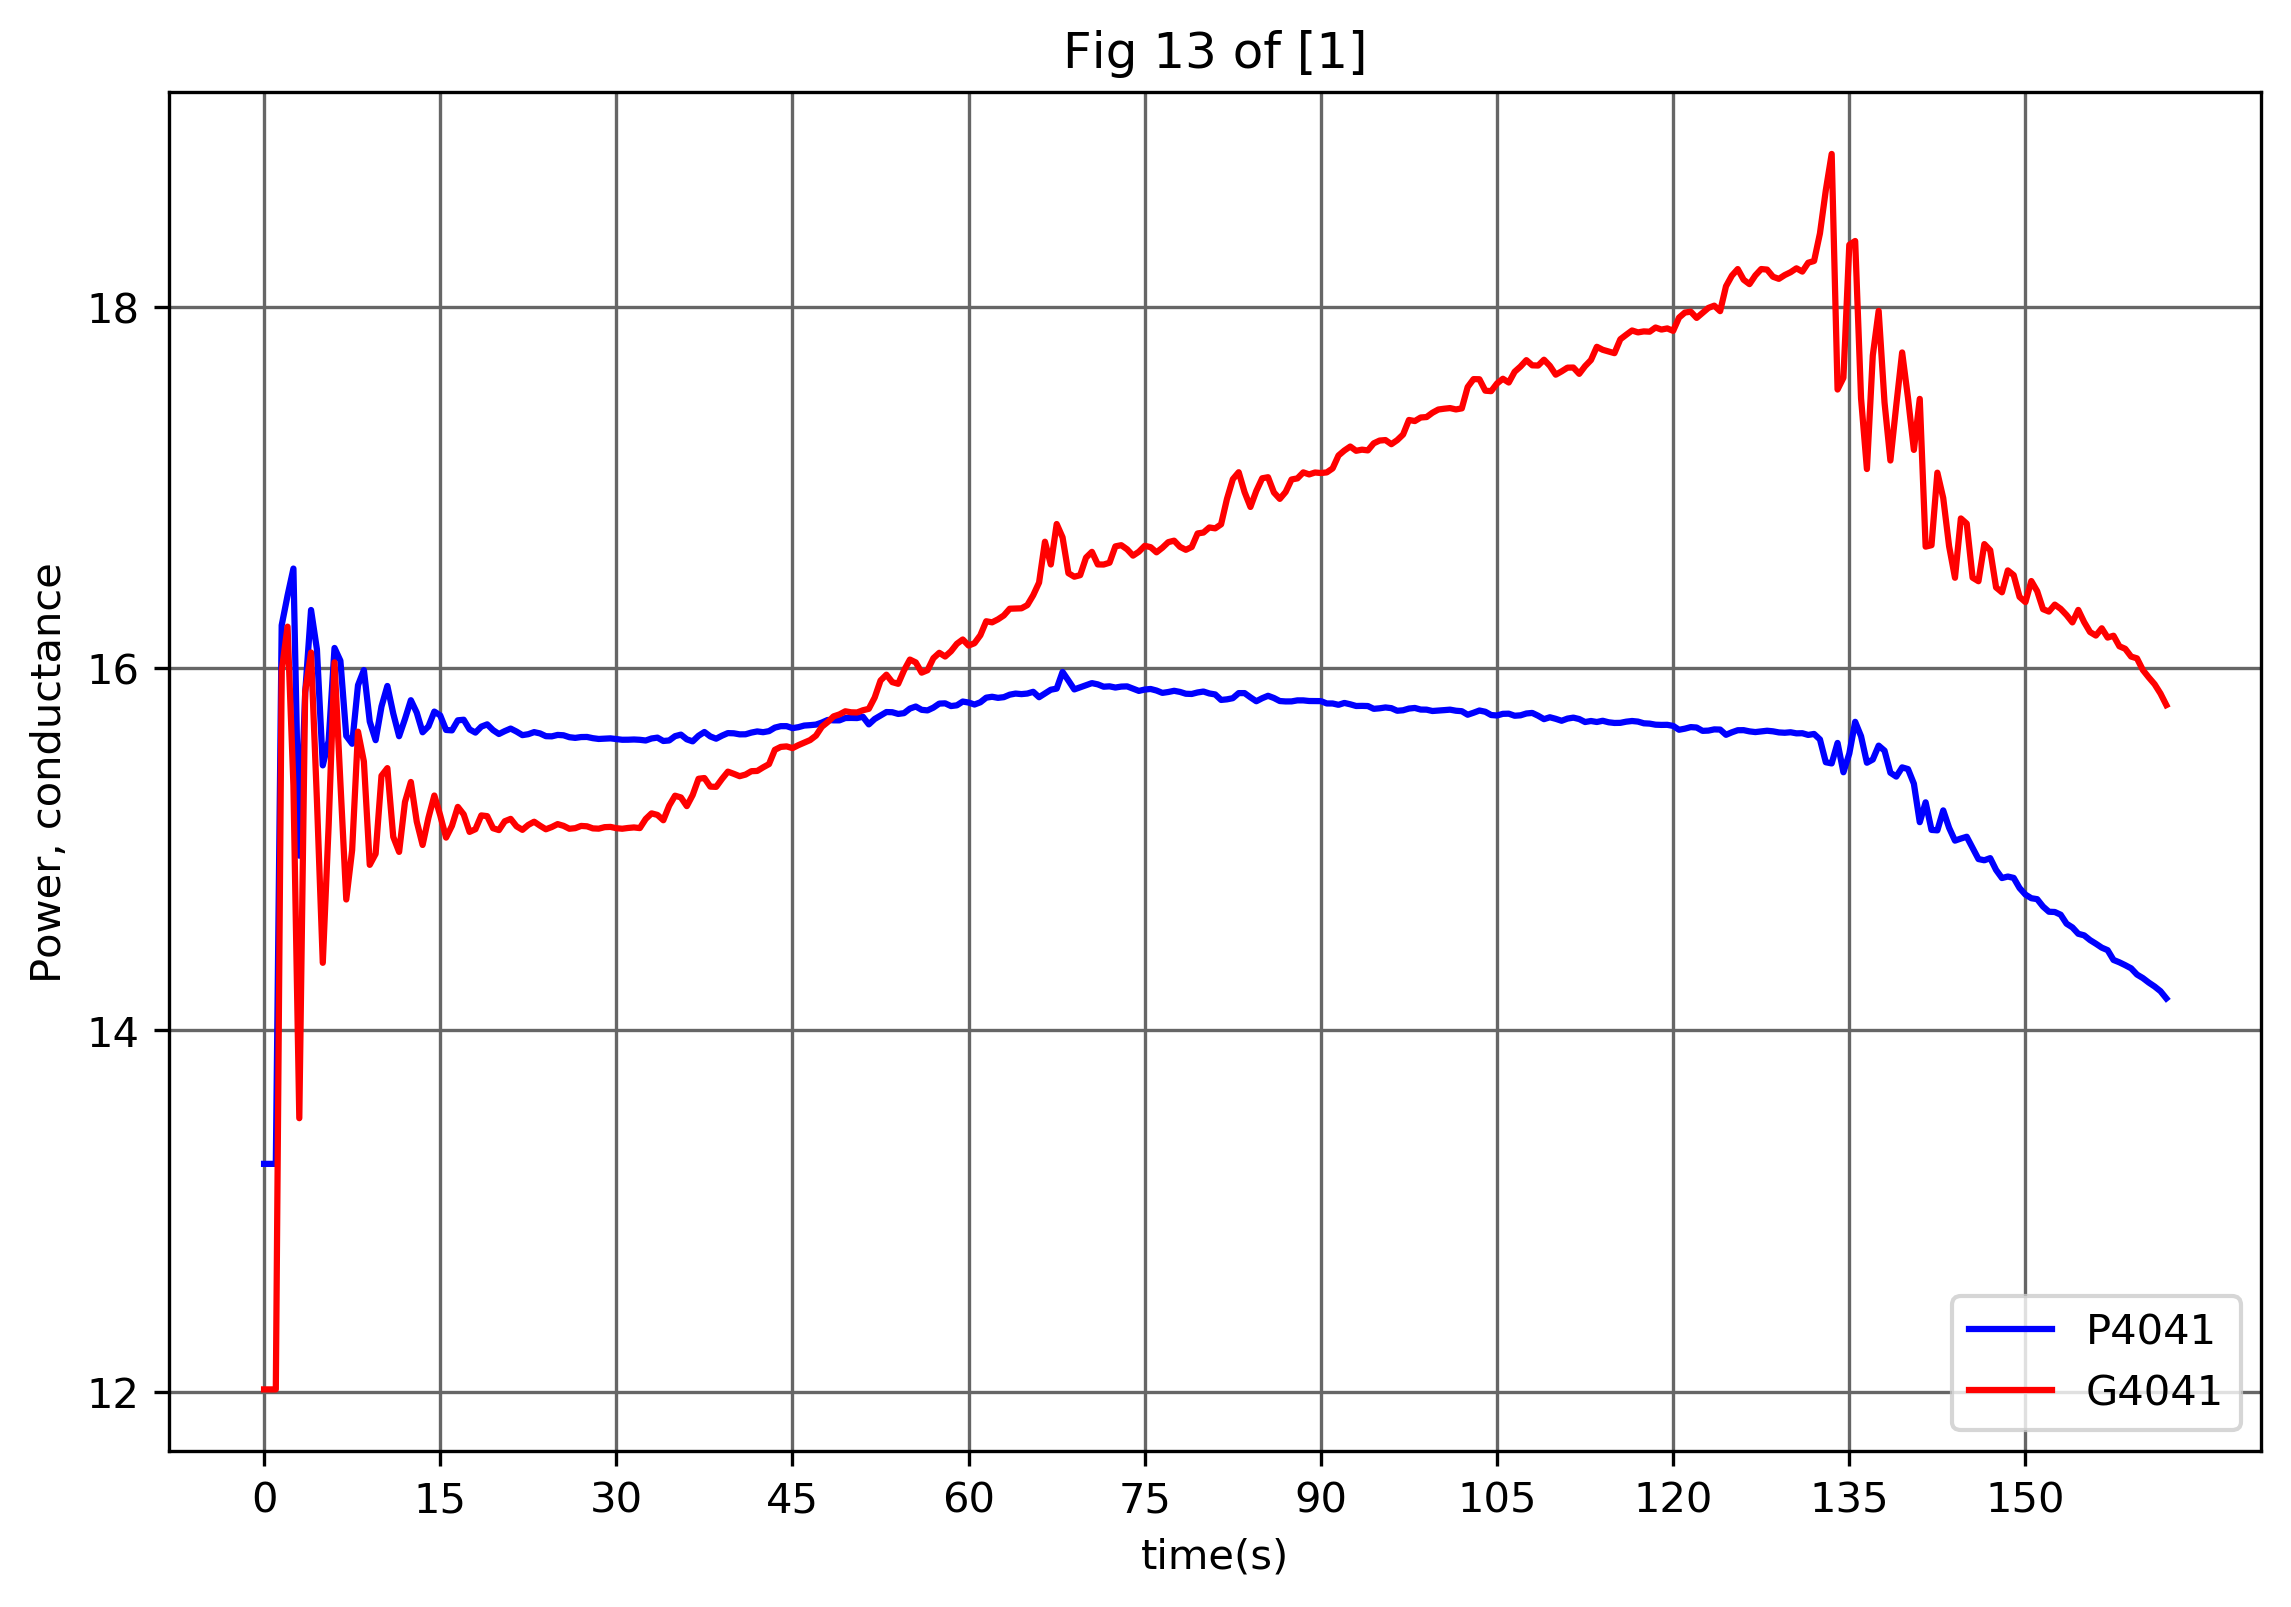

In [14]:
fig=plt.figure(figsize=(9,6), dpi= 300, facecolor='w', edgecolor='k')
plt.plot(rawtime, lP4041, 'b', label="P4041")
plt.plot(rawtime, lG4041, 'r', label="G4041")
plt.ylabel('Power, conductance')
plt.xlabel('time(s)')
plt.legend(loc='lower right')
plt.xticks(np.arange(0, 160, 15))
plt.yticks(np.arange(12, 20, 2))
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.title('Fig 13 of [1]')
plt.show()

The same historical variation of the power and conductance for the second boundary bus. This figure is not in [\[1\]](#bib).

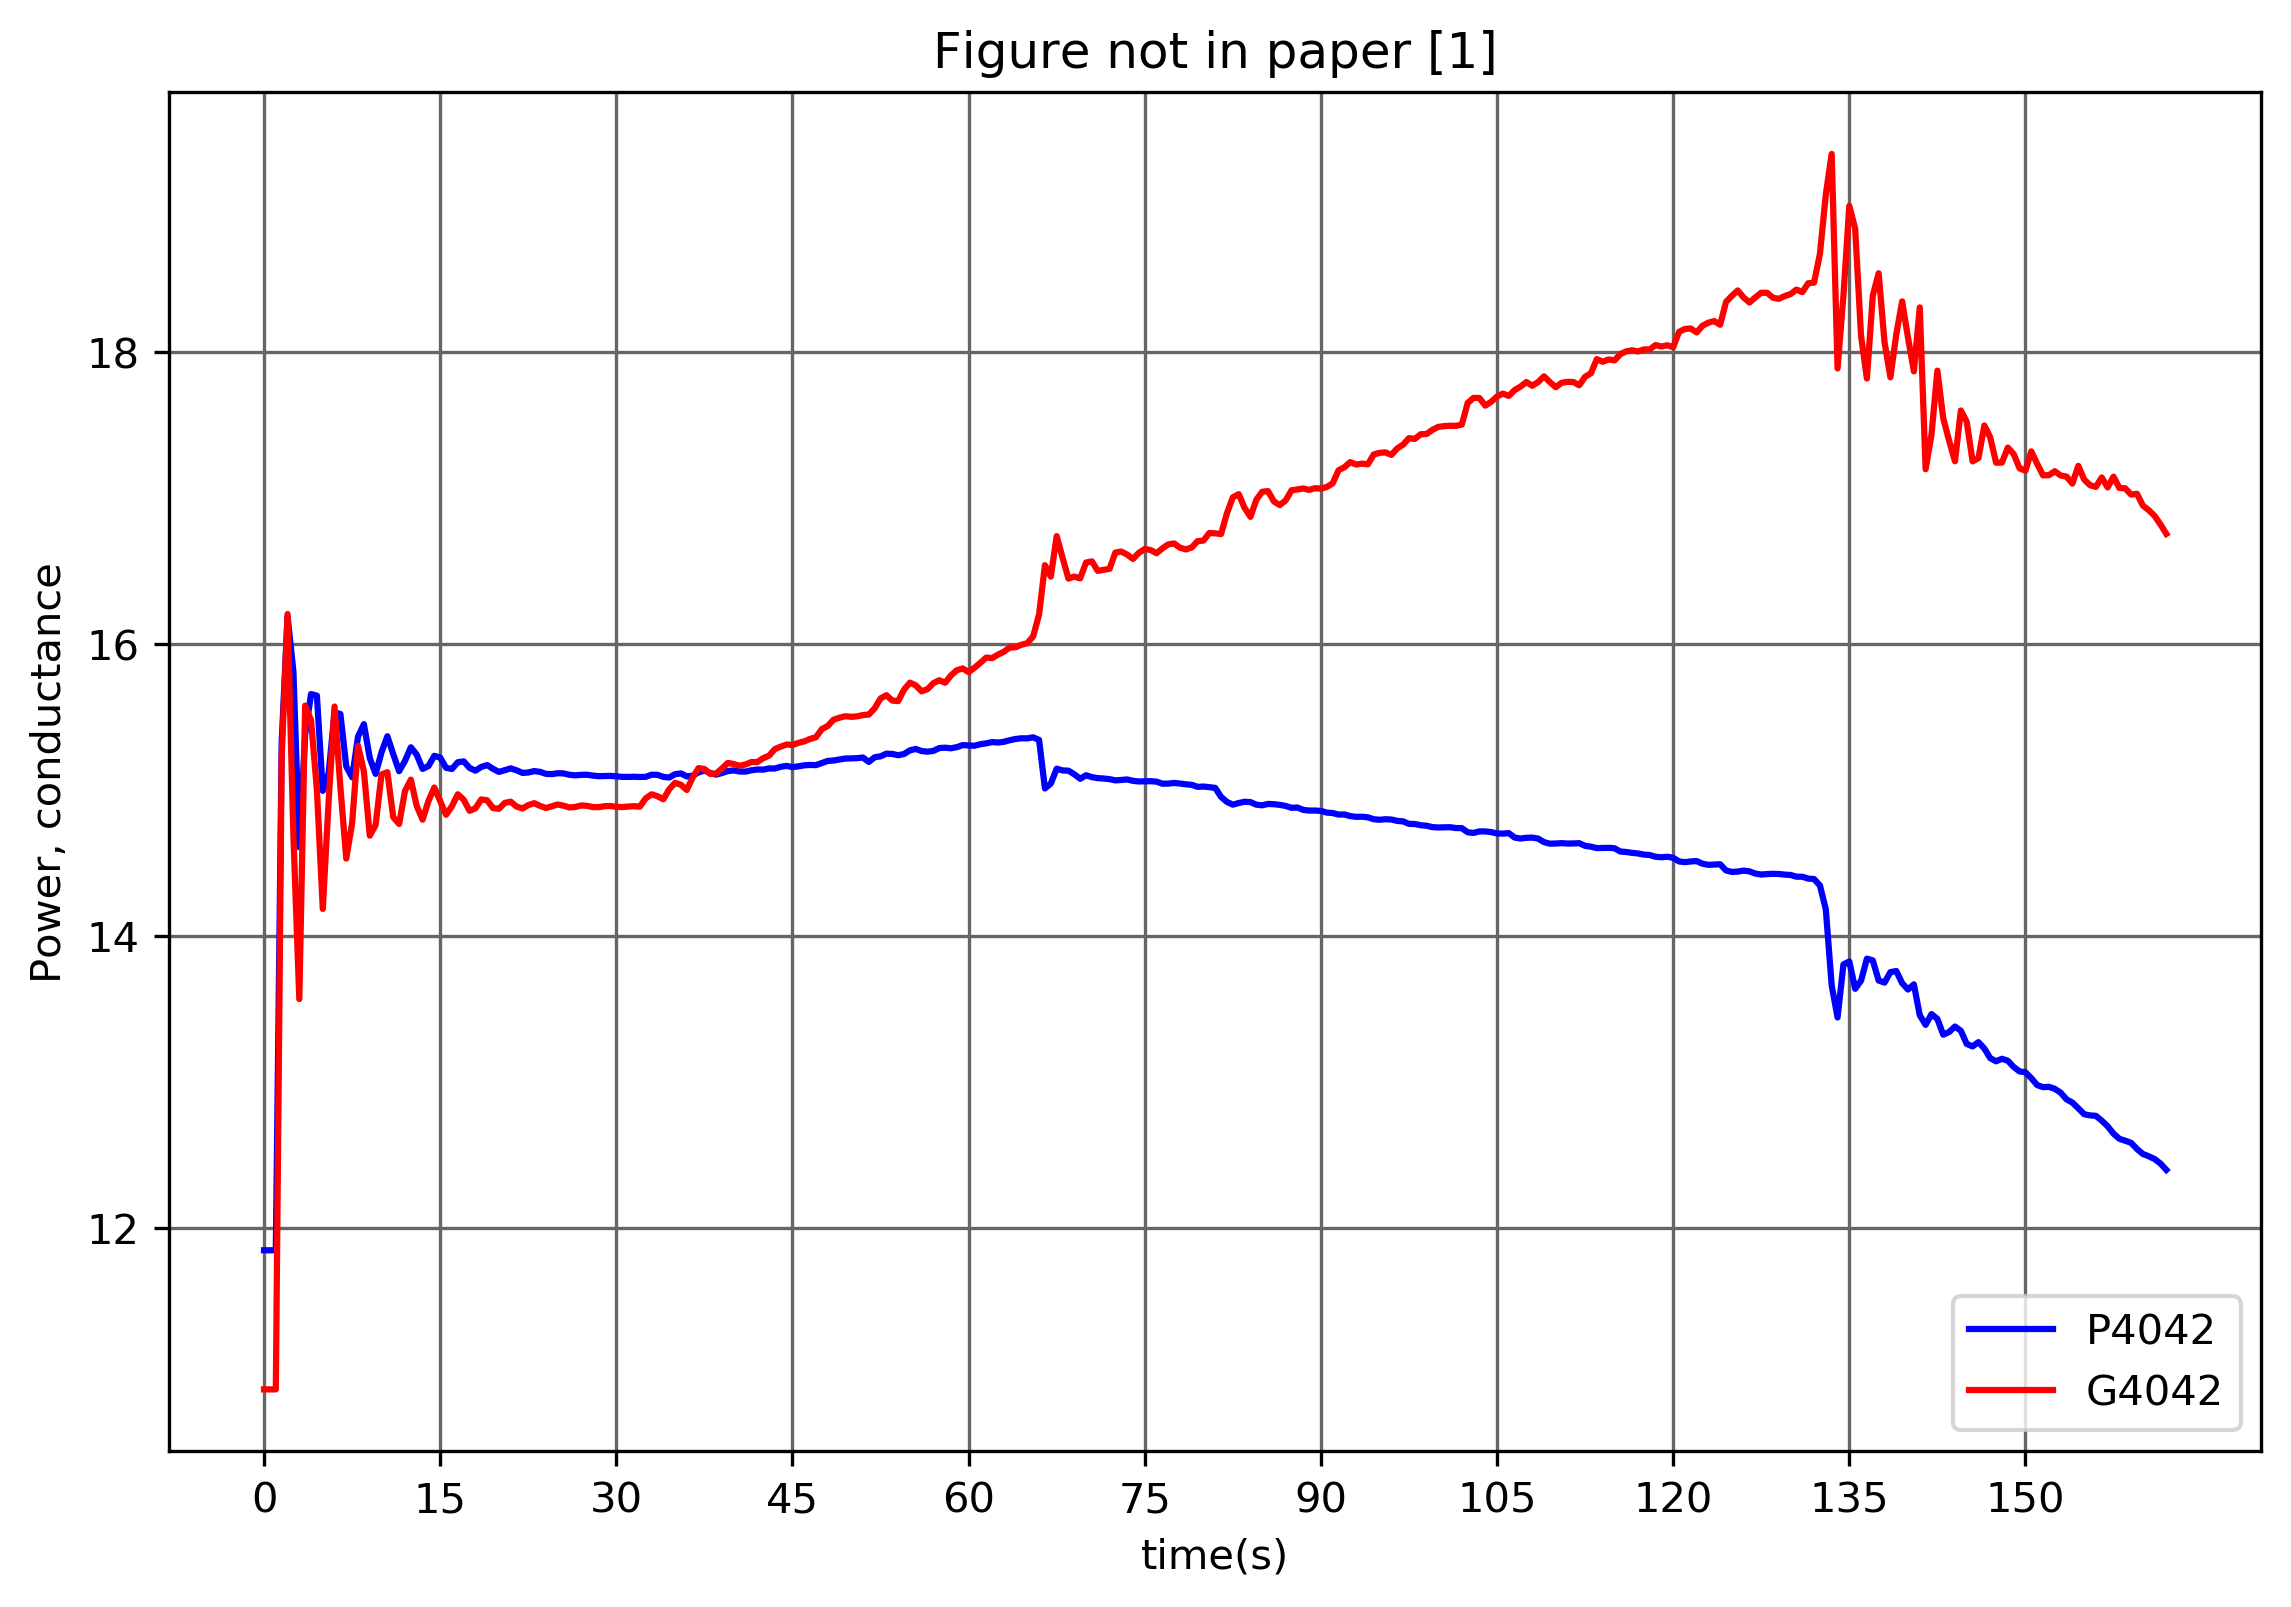

In [15]:
fig=plt.figure(figsize=(9,6), dpi= 300, facecolor='w', edgecolor='k')
plt.plot(rawtime, lP4042, 'b', label="P4042")
plt.plot(rawtime, lG4042, 'r', label="G4042")
plt.ylabel('Power, conductance')
plt.xlabel('time(s)')
plt.legend(loc='lower right')
plt.xticks(np.arange(0, 160, 15))
plt.yticks(np.arange(12, 20, 2))
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.title('Figure not in paper [1]')
plt.show()

We finalise the analysis by deleting the case and the simulator instance:

In [16]:
del(ram)
del(case)

# Conclusion

This post showed how a dynamic simulator can be used to implement and test WAMC algorithms. Dynamic simulators able to pause/start/restart and allowing interaction with Python are invaluable in testing these algorithms.

# References
<a id='bib'></a>

\[1\] *C. D. Vournas, C. Lambrou, P. Mandoulidis, “Voltage Stability Monitoring from a Transmission Bus PMU”, IEEE Transactions on Power Systems, Vol. 32, no. 4, May 2017, pp. 3266 - 3274*

\[2\] *IEEE PES Task Force, “Test Systems for Voltage Stability Analysis and Security Assessment,” IEEE Power & Energy Society, Tech. Rep. PES-TR19, 2015. [Online]. Available: http://resourcecenter.ieee-pes.org/pes/product/technical-publications/PESTR19*